## Importujeme potrebné balíky

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Načítavanie dát z Yahoo Finance

In [2]:
raw_data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = "1994-01-07", 
                              end = "2019-09-01", interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 completed


In [3]:
df_comp = raw_data.copy()

In [4]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

In [5]:
df_comp = df_comp.iloc[1:]
del df_comp['^N225']
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

## Vytvorenie výnosov

In [6]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1).mul(100)
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1).mul(100)
df_comp['ret_dax'] = df_comp.dax.pct_change(1).mul(100)
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1).mul(100)

## Rozdelenie dát 80/20

In [7]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## Fitovanie modelu ARIMA(1,0,0)

In [8]:
model_ar = ARIMA(df.ftse, order = (1,0,0))
results_ar = model_ar.fit()

## Jednoduchá prognóza

In [9]:
df.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei
,,,,,,,,
Date,,,,,,,,
2014-07-08,1963.709961,9772.669922,6738.500000,15314.410156,-0.704880,-1.245695,-1.346653,-0.422839
2014-07-09,1972.829956,9808.200195,6718.000000,15302.650391,0.464427,-0.304222,0.363568,-0.076789
2014-07-10,1964.680054,9659.129883,6672.399902,15216.469727,-0.413107,-0.678775,-1.519854,-0.563175
2014-07-11,1967.569946,9666.339844,6690.200195,15164.040039,0.147092,0.266775,0.074644,-0.344559
2014-07-14,1977.099976,9783.009766,6746.100098,15296.820312,0.484355,0.835549,1.206971,0.875626


In [10]:
# vytvorte premenné, ktoré nám pomôžu ľahko meniť obdobia namiesto toho, aby sme ich zakaždým zadávali
# uistite sa, že dátumy začiatku a ukončenia sú pracovné dni, inak kód spôsobí chybu
start_date = "2014-07-15"
end_date_a = "2015-01-01"

In [11]:
end_date = "2019-10-23"
df_pred = results_ar.predict(start = start_date, end = end_date)

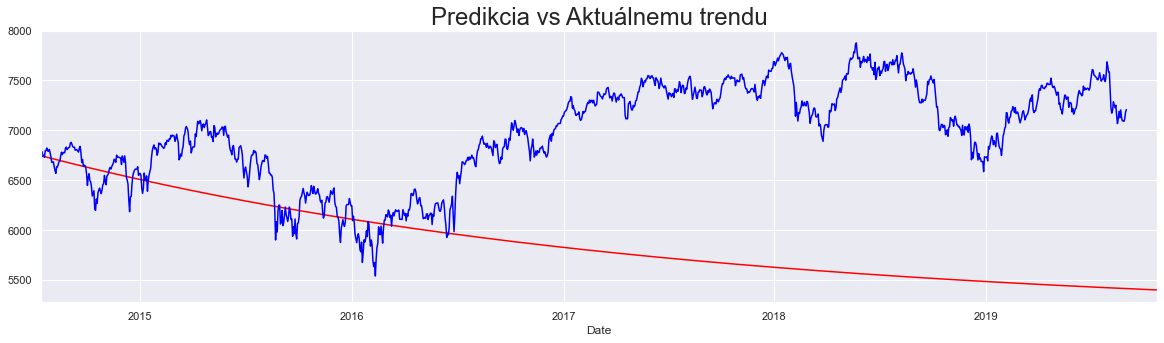

In [12]:
df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ftse[start_date:end_date].plot(color = "blue")
plt.title("Predikcia vs Aktuálnemu trendu", size = 24)
plt.show()

### Použitie výnosy namiesto cien

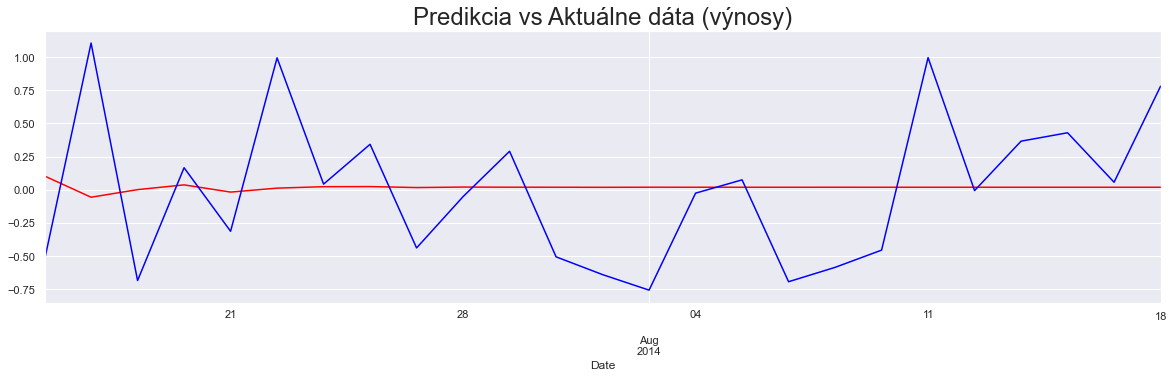

In [33]:
end_date = "2014-08-18"

model_ret_ar = ARIMA(df.ret_ftse[1:], order = (5,0,0))
results_ret_ar = model_ret_ar.fit()

df_pred_ar = results_ret_ar.predict(start = start_date, end = end_date) 

df_pred_ar[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predikcia vs Aktuálne dáta (výnosy)", size = 24)
plt.show()

In [14]:
results_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5351
Model:                     ARMA(5, 0)   Log Likelihood               -8306.820
Method:                       css-mle   S.D. of innovations              1.143
Date:                Mon, 02 May 2022   AIC                          16627.639
Time:                        18:14:49   BIC                          16673.735
Sample:                    01-10-1994   HQIC                         16643.740
                         - 07-14-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0192      0.013      1.437      0.151      -0.007       0.045
ar.L1.ret_ftse    -0.0213      0.014     -1.558      0.119      -0.048       0.005
ar.L2.ret_ftse    -0.0523      0.014     -3.837      0.000      -0.079      -0.026
ar.L3.ret_ftse    -0.0804      0.014     -5.907      0.000      -0.107      -0.054
ar.L4.ret_ftse     0.0422      0.014      3.095      0.002       0.015       0.069
ar.L5.ret_ftse    -0.0573      0.014     -4.198      0.000      -0.084      -0.031
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5635           -0.0000j            1.5635           -0.5000
AR.2           -0.2941           -1.7414j            1.7661           -0.2766
AR.3           -0.2941           +1.7414j            1.7661            0.2766
AR.4            1.4442           -1.2222j            1.8920           -0.1118
AR.5            1.4442           +1.2222j            1.8920            0.1118
-----------------------------------------------------------------------------
"""

### MA

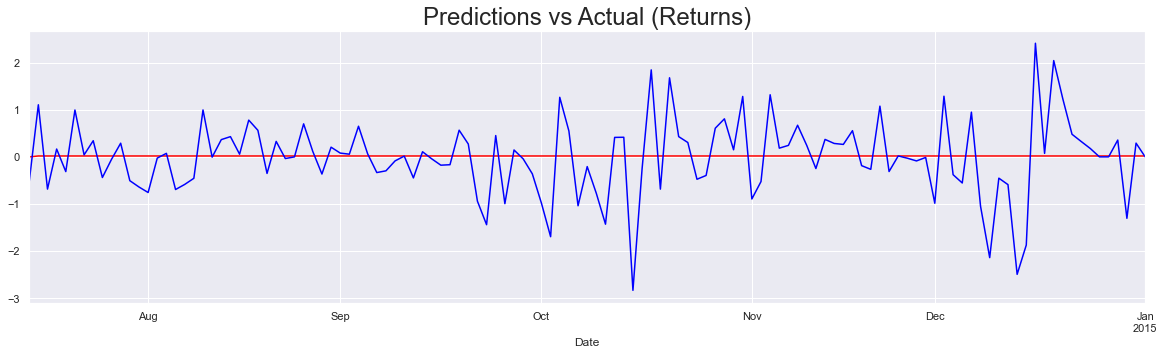

In [15]:
end_date = "2015-01-01"

model_ret_ma = ARIMA(df.ret_ftse[1:], order=(0,0,1))
results_ret_ma = model_ret_ma.fit()

df_pred_ma = results_ret_ma.predict(start = start_date, end = end_date) 

df_pred_ma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [16]:
df_pred_ma.head()

2014-07-15   -0.001258
2014-07-16    0.019178
2014-07-17    0.019178
2014-07-18    0.019178
2014-07-21    0.019178
Freq: B, dtype: float64

### ARMA

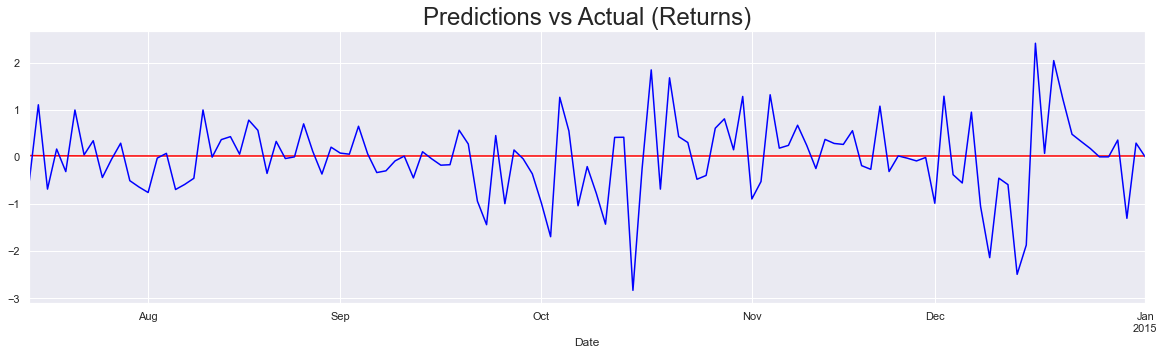

In [17]:
model_ret_arma = ARIMA(df.ret_ftse[1:], order=(1,0,1))
results_ret_arma = model_ret_arma.fit()

df_pred_arma = results_ret_arma.predict(start = start_date, end = end_date)

df_pred_arma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [18]:
df_pred_arma.head()

2014-07-15    0.027396
2014-07-16    0.025563
2014-07-17    0.024142
2014-07-18    0.023039
2014-07-21    0.022183
Freq: B, dtype: float64

In [19]:
results_ret_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5351
Model:                     ARMA(1, 1)   Log Likelihood               -8330.429
Method:                       css-mle   S.D. of innovations              1.148
Date:                Mon, 02 May 2022   AIC                          16668.858
Time:                        18:14:53   BIC                          16695.198
Sample:                    01-10-1994   HQIC                         16678.058
                         - 07-14-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0192      0.012      1.546      0.122      -0.005       0.044
ar.L1.ret_ftse     0.7759      0.073     10.675      0.000       0.633       0.918
ma.L1.ret_ftse    -0.8224      0.066    -12.533      0.000      -0.951      -0.694
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2889           +0.0000j            1.2889            0.0000
MA.1            1.2159           +0.0000j            1.2159            0.0000
-----------------------------------------------------------------------------
"""

In [20]:
df_pred_arma.tail()

2014-12-26    0.019221
2014-12-29    0.019221
2014-12-30    0.019221
2014-12-31    0.019221
2015-01-01    0.019221
Freq: B, dtype: float64

### ARIMA

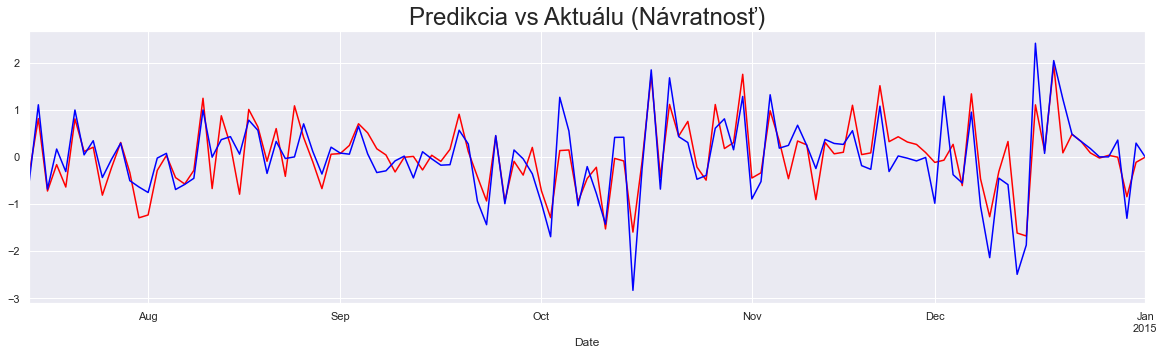

In [21]:
model_ret_armax = ARIMA(df.ret_ftse[1:], exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:], order = (1,0,1))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test[["ret_spx","ret_dax","ret_nikkei"]][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predikcia vs Aktuálu (Návratnosť)", size = 24)
plt.show()

In [22]:
results_ret_armax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5351
Model:                     ARMA(1, 1)   Log Likelihood               -5563.206
Method:                       css-mle   S.D. of innovations              0.684
Date:                Mon, 02 May 2022   AIC                          11140.412
Time:                        18:14:55   BIC                          11186.507
Sample:                    01-10-1994   HQIC                         11156.512
                         - 07-14-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0061      0.007     -0.811      0.418      -0.021       0.009
ret_spx            0.1054      0.010     10.394      0.000       0.086       0.125
ret_dax            0.5483      0.008     66.525      0.000       0.532       0.564
ret_nikkei         0.0745      0.007     11.306      0.000       0.062       0.087
ar.L1.ret_ftse     0.4120      0.098      4.207      0.000       0.220       0.604
ma.L1.ret_ftse    -0.5301      0.091     -5.814      0.000      -0.709      -0.351
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.4271           +0.0000j            2.4271            0.0000
MA.1            1.8866           +0.0000j            1.8866            0.0000
-----------------------------------------------------------------------------
"""

### SARMA

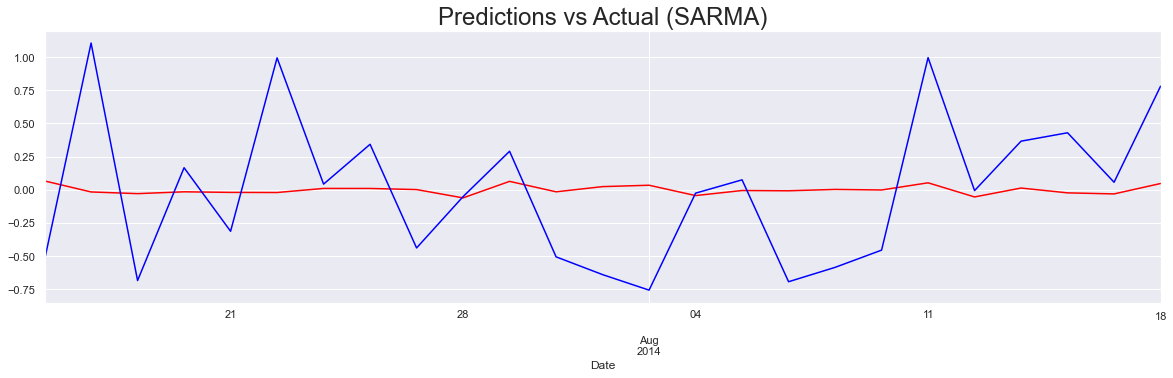

In [23]:
end_date = "2014-08-18"
model_ret_sarma = SARIMAX(df.ret_ftse[1:], order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarma = model_ret_sarma.fit()

df_pred_sarma = results_ret_sarma.predict(start = start_date, end = end_date)

df_pred_sarma[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (SARMA)", size = 24)
plt.show()

### Auto ARIMA hodnoty FTSE

In [24]:
model_auto_ftse = auto_arima(df.ftse, exogenous = df[['spx', 'dax', 'nikkei']],
                       m = 5, max_p = 5, max_q = 5)

In [25]:
df_auto_pred_ftse = pd.DataFrame(model_auto_ftse.predict(n_periods = len(df_test[start_date:end_date]),
                            exogenous = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date]),
                            index = df_test[start_date:end_date].index)

In [26]:
model_auto_ftse.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 5352
Model:             SARIMAX(4, 1, 0)x(2, 0, [1], 5)   Log Likelihood              -26526.308
Date:                             Mon, 02 May 2022   AIC                          53074.617
Time:                                     18:26:41   BIC                          53147.052
Sample:                                 01-07-1994   HQIC                         53099.917
                                      - 07-14-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            0.4443      0.029     15.075      0.000       0.387       0.502
dax            0.5600      0.005    104.400      0.000       0.549       0.571
nikkei         0.0240      0.002     12.139      0.000       0.020       0.028
ar.L1         -0.0869      0.008    -10.297      0.000      -0.103      -0.070
ar.L2         -0.0250      0.011     -2.321      0.020      -0.046      -0.004
ar.L3         -0.0592      0.011     -5.597      0.000      -0.080      -0.038
ar.L4         -0.0259      0.010     -2.619      0.009      -0.045      -0.007
ar.S.L5        0.3691      0.215      1.716      0.086      -0.052       0.791
ar.S.L10      -0.0277      0.014     -2.015      0.044      -0.055      -0.001
ma.S.L5       -0.3959      0.214     -1.847      0.065      -0.816       0.024
sigma2      1181.7544     13.632     86.691      0.000    1155.036    1208.472
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5111.76
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.00
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

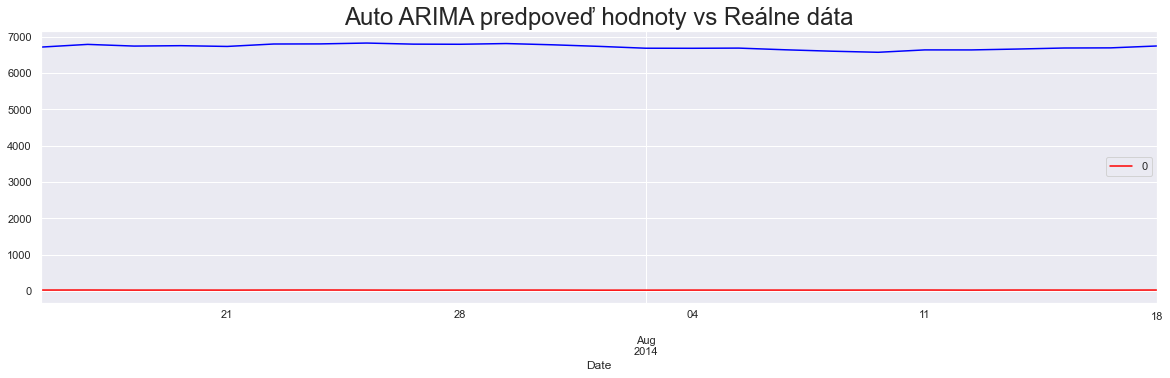

In [27]:
df_auto_pred_ftse.plot(figsize = (20,5), color = "red")
df_test.ftse[start_date:end_date].plot(color = "blue")
plt.title("Auto ARIMA predpoveď hodnoty vs Reálne dáta", size = 24)
plt.show()

### Auto ARIMA výnosov FTSE s 3exog

In [28]:
model_auto_ret = auto_arima(df.ret_ftse[1:], exogenous = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:],
                       max_p = 5, max_q = 5)

In [29]:
df_auto_pred_ret = pd.DataFrame(model_auto_ret.predict(n_periods = len(df_test[start_date:end_date_a]),
                            exogenous = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date_a]),
                            index = df_test[start_date:end_date_a].index)

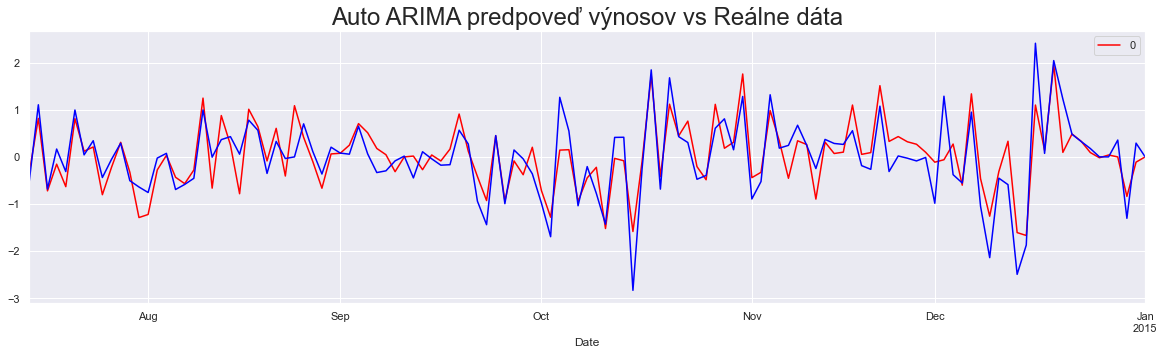

In [30]:
df_auto_pred_ret.plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date_a].plot(color = "blue")
plt.title("Auto ARIMA predpoveď výnosov vs Reálne dáta", size = 24)
plt.show()

### Porovnanie všetkých modelov (výnosy)

In [ ]:
end_date = "2015-01-01"
df_pred_ar[start_date:end_date].plot(figsize = (20,10), color = "yellow")
df_pred_ma[start_date:end_date].plot(color = "pink")
df_pred_arma[start_date:end_date].plot(color = "cyan")
df_pred_armax[start_date:end_date].plot(color = "green")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.legend(['AR','MA','ARMA','ARMAX'])
plt.title("Všetkoy modely", size = 24)
plt.show()